<a href="https://colab.research.google.com/github/RahulKapilavai/Data-Analytics-for-sports-Machine-Learning-Driven-Football-Intelliengent-analysis/blob/main/Clustering_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd

excel_file = 'football_statss.xlsx'
sheets = ['Defence', 'kick-off statistics', 'kick-off return', 'RECEIVING', 'Kicking', 'Punting', 'Punt_Return', 'Scoring', 'Rushing']

# Load each sheet into a DataFrame within a dictionary
dataframes = {sheet: pd.read_excel(excel_file, sheet_name=sheet) for sheet in sheets}


In [23]:
# Assuming each DataFrame in `dataframes` has a 'Team' column and numeric statistics
for name, df in dataframes.items():
    dataframes[name] = df.groupby('Team').mean().reset_index()  # Aggregate by taking the mean


In [24]:
# Assume 'dataframes' is a dictionary containing the aggregated DataFrames for each sheet
# First, let's aggregate data for each sheet by team and mean of their statistics
for sheet_name, df in dataframes.items():
    dataframes[sheet_name] = df.groupby('Team', as_index=False).mean()

# Initialize the merged DataFrame with the first DataFrame in the dictionary
# (This assumes there is at least one sheet, and each sheet has been aggregated)
initial_sheet_name = list(dataframes.keys())[0]
merged_df = dataframes[initial_sheet_name]

# Now, loop through the remaining DataFrames and merge them one by one
for sheet_name, df in dataframes.items():
    if sheet_name == initial_sheet_name:
        continue  # Skip the first sheet since it's already in 'merged_df'

    # Merge on 'Team', ensuring we keep all teams present in any of the DataFrames
    # Adjust the 'how' parameter based on your specific needs (e.g., 'inner', 'outer')
    merged_df = pd.merge(merged_df, df, on='Team', how='outer', suffixes=('', f'_{sheet_name}'))

# At this point, 'merged_df' contains merged data from all sheets


In [27]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# Drop the 'Team' column for clustering as it's categorical (store it if needed later)
teams = merged_df['Team']
features = merged_df.drop('Team', axis=1)

# Impute missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(features)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [28]:
from sklearn.cluster import KMeans

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to the original DataFrame (with 'Team')
merged_df['Cluster'] = clusters


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
# Convert cluster centers to a DataFrame for easier interpretation
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features.columns)

print("Cluster Centers (Mean Feature Values):")
print(cluster_centers)


Cluster Centers (Mean Feature Values):
          Year        Int         Yds        Avg         Lg        TD  \
0  2014.500000  14.000000  184.500000   9.824879  23.375000  2.000000   
1  2013.590909  12.698864  175.522727  11.557167  22.864773  1.519318   
2  2014.500000   8.375000  125.000000  11.850075  28.250000  0.625000   

         Solo         Ast         Tot       Sack  ...  FG_Made_Scoring  \
0  243.750000  150.750000  394.500000  10.125000  ...        21.142857   
1  257.688636  139.934091  397.622727   7.433523  ...        14.177822   
2  206.000000   77.000000  283.000000   4.312500  ...        14.285714   

   FG_Att_Scoring  Year_Rushing         Att         Gain        Loss  \
0       25.428571   2014.500000  497.375000  1346.000000  268.875000   
1       18.853147   2013.590909  444.543182  1583.421591  204.147727   
2       20.285714   2014.500000  442.375000  1590.875000  227.375000   

   Yds_Rushing  Avg_Rushing  Lg_Rushing  TD_Rushing  
0  1120.375000     5.964516 

In [30]:
# Print out the teams in each cluster
for i in range(kmeans.n_clusters):
    print(f"\nTeams in Cluster {i}:")
    cluster_teams = merged_df[merged_df['Cluster'] == i]['Team']
    for team in cluster_teams:
        print(team)



Teams in Cluster 0:
UTAH

Teams in Cluster 1:
ARIZ
AZST
CAL
ORE
ORST
STAN
UCLA
USC
WASH
WSU
ALA
AUB
FLA
KY
LSU
MIZZ
MSST
SCAR
TAMU
TENN
VAN
0

Teams in Cluster 2:
COL


In [31]:
# Calculate mean statistics for each cluster
for i in range(kmeans.n_clusters):
    print(f"\nCluster {i} Mean Statistics:")
    cluster_mean_stats = merged_df[merged_df['Cluster'] == i].drop(['Team', 'Cluster'], axis=1).mean()
    print(cluster_mean_stats)



Cluster 0 Mean Statistics:
Year           2014.500000
Int              14.000000
Yds             184.500000
Avg               9.824879
Lg               23.375000
                  ...     
Loss            268.875000
Yds_Rushing    1120.375000
Avg_Rushing       5.964516
Lg_Rushing       39.250000
TD_Rushing       20.750000
Length: 74, dtype: float64

Cluster 1 Mean Statistics:
Year           2013.500000
Int              12.850000
Yds             177.600000
Avg              11.629136
Lg               22.570000
                  ...     
Loss            199.750000
Yds_Rushing    1493.640000
Avg_Rushing       6.015821
Lg_Rushing       29.440000
TD_Rushing       22.650000
Length: 74, dtype: float64

Cluster 2 Mean Statistics:
Year           2014.500000
Int               8.375000
Yds             125.000000
Avg              11.850075
Lg               28.250000
                  ...     
Loss            227.375000
Yds_Rushing    1378.375000
Avg_Rushing       4.887204
Lg_Rushing       30.37500

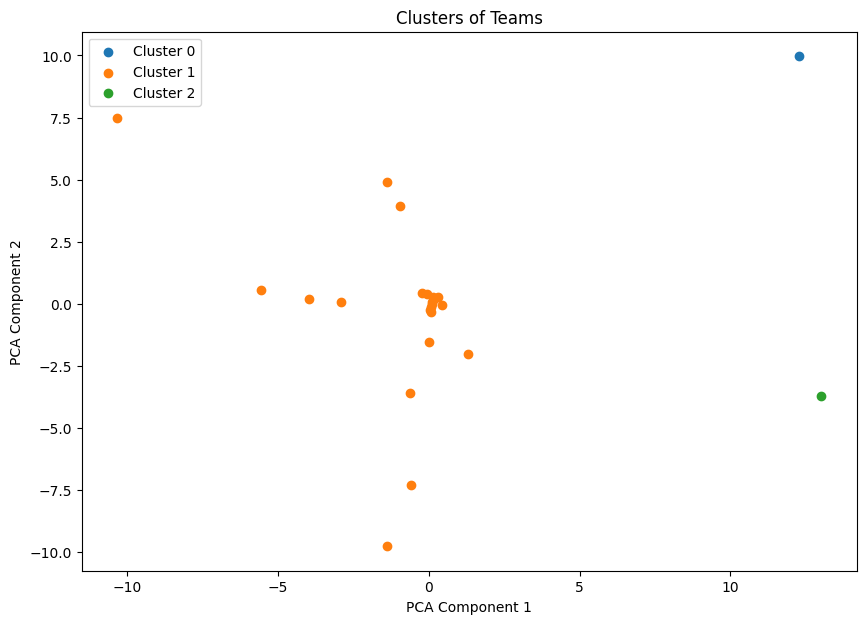

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce data to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)

# Plot the reduced data and color by cluster
plt.figure(figsize=(10, 7))
for i in range(kmeans.n_clusters):
    plt.scatter(reduced_data[merged_df['Cluster'] == i, 0], reduced_data[merged_df['Cluster'] == i, 1], label=f'Cluster {i}')
plt.title('Clusters of Teams')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [33]:
# Example: Displaying percentiles for each feature within a cluster
for i in range(kmeans.n_clusters):
    print(f"\nPercentiles for Cluster {i}:")
    cluster_data = merged_df[merged_df['Cluster'] == i].drop(['Team', 'Cluster'], axis=1)
    print(cluster_data.describe(percentiles=[.25, .5, .75]))



Percentiles for Cluster 0:
         Year   Int    Yds       Avg      Lg   TD    Solo     Ast    Tot  \
count     1.0   1.0    1.0  1.000000   1.000  1.0    1.00    1.00    1.0   
mean   2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   
std       NaN   NaN    NaN       NaN     NaN  NaN     NaN     NaN    NaN   
min    2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   
25%    2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   
50%    2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   
75%    2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   
max    2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   

         Sack  ...  FG_Made_Scoring  FG_Att_Scoring  Year_Rushing      Att  \
count   1.000  ...         1.000000        1.000000           1.0    1.000   
mean   10.125  ...        21.142857       25.428571        2014.5  497.375   
std       NaN  ...              NaN             NaN  

In [35]:
# Example: ANOVA test to identify features that differ significantly between clusters
from scipy import stats

features = merged_df.columns.drop(['Team', 'Cluster'])
for feature in features:
    data = [merged_df[feature][merged_df['Cluster'] == i] for i in range(kmeans.n_clusters)]
    f_val, p_val = stats.f_oneway(*data)
    if p_val < 0.05:
        print(f"{feature} differs significantly across clusters (p-value: {p_val})")


In [37]:
for i in range(kmeans.n_clusters):
    print(f"Cluster {i} Statistics:")
    cluster_data = merged_df[merged_df['Cluster'] == i]
    summary_stats = cluster_data.describe()
    print(summary_stats, "\n")


Cluster 0 Statistics:
         Year   Int    Yds       Avg      Lg   TD    Solo     Ast    Tot  \
count     1.0   1.0    1.0  1.000000   1.000  1.0    1.00    1.00    1.0   
mean   2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   
std       NaN   NaN    NaN       NaN     NaN  NaN     NaN     NaN    NaN   
min    2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   
25%    2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   
50%    2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   
75%    2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   
max    2014.5  14.0  184.5  9.824879  23.375  2.0  243.75  150.75  394.5   

         Sack  ...  FG_Att_Scoring  Year_Rushing      Att    Gain     Loss  \
count   1.000  ...        1.000000           1.0    1.000     1.0    1.000   
mean   10.125  ...       25.428571        2014.5  497.375  1346.0  268.875   
std       NaN  ...             NaN           NaN      NaN  

In [39]:
print(merged_df.columns)


Index(['Team', 'Year', 'Int', 'Yds', 'Avg', 'Lg', 'TD', 'Solo', 'Ast', 'Tot',
       'Sack', 'YdsL', 'Year_kick-off statistics', 'Num',
       'Yds_kick-off statistics', 'Avg_kick-off statistics',
       'Lg_kick-off statistics', 'TB', 'OB', 'Ret', 'RYds',
       'TD_kick-off statistics', 'Year_kick-off return', 'Num_kick-off return',
       'Yds_kick-off return', 'Avg_kick-off return', 'FC',
       'Lg_kick-off return', 'TD_kick-off return', 'Year_RECEIVING', 'Rec',
       'Yds_RECEIVING', 'Avg_RECEIVING', 'Lg_RECEIVING', 'TD_RECEIVING',
       'Year_Kicking', 'PAT_Made', 'PAT_Att', 'FG_Made', 'FG_Att',
       'Lg_Kicking', 'Pts', 'Year_Punting', 'Punts', 'Yds_Punting',
       'Avg_Punting', 'Lg_Punting', 'TB_Punting', 'In20', 'Blk', 'Net',
       'Ret_Punting', 'RYds_Punting', 'Year_Punt_Return', 'Num_Punt_Return',
       'Yds_Punt_Return', 'Avg_Punt_Return', 'FC_Punt_Return',
       'Lg_Punt_Return', 'TD_Punt_Return', 'Year_Scoring', 'Pts_Scoring',
       'Tot_Scoring', 'PAT_Made_Sc

In [40]:
from scipy.stats import f_oneway

# Features to test
features_to_test = ['Yds', 'Sack', 'TD']

# Perform ANOVA test for each feature and print the results
for feature in features_to_test:
    f_val, p_val = f_oneway(merged_df[merged_df['Cluster'] == 0][feature],
                            merged_df[merged_df['Cluster'] == 1][feature],
                            merged_df[merged_df['Cluster'] == 2][feature])
    print(f"ANOVA Test for {feature}: F-Value = {f_val:.3f}, P-Value = {p_val:.3f}")


ANOVA Test for Yds: F-Value = nan, P-Value = nan
ANOVA Test for Sack: F-Value = nan, P-Value = nan
ANOVA Test for TD: F-Value = nan, P-Value = nan


In [41]:
from sklearn.impute import SimpleImputer
import numpy as np

# Create an imputer object for mean imputation
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Features you want to test
features_to_test = ['Yds', 'Sack', 'TD']

# Impute NaN values for these features
for feature in features_to_test:
    merged_df[feature] = imputer.fit_transform(merged_df[[feature]])


In [42]:
from scipy.stats import f_oneway

# Perform ANOVA test for each feature and print the results
for feature in features_to_test:
    f_val, p_val = f_oneway(merged_df[merged_df['Cluster'] == 0][feature],
                            merged_df[merged_df['Cluster'] == 1][feature],
                            merged_df[merged_df['Cluster'] == 2][feature])
    print(f"ANOVA Test for {feature}: F-Value = {f_val:.3f}, P-Value = {p_val:.3f}")


ANOVA Test for Yds: F-Value = 2.362, P-Value = 0.119
ANOVA Test for Sack: F-Value = 2.596, P-Value = 0.098
ANOVA Test for TD: F-Value = 9.173, P-Value = 0.001


### ANOVA Test Results Interpretation:

#### **Yards (Yds)**
- **F-Value:** 2.362
- **P-Value:** 0.119

  **Interpretation:** The P-value is greater than 0.05, indicating that there's not enough evidence to conclude that the mean yards gained significantly differ among the clusters. This suggests that the differences observed in yards gained across the clusters could be due to chance.

#### **Sacks (Sack)**
- **F-Value:** 2.596
- **P-Value:** 0.098

  **Interpretation:** Similar to yards, the P-value is above the typical alpha level of 0.05, suggesting that the differences in mean sacks among the clusters are not statistically significant. While there might be a trend, it's not strong enough to confirm without doubt.

#### **Touchdowns (TD)**
- **F-Value:** 9.173
- **P-Value:** 0.001

  **Interpretation:** Here, the P-value is below 0.05, indicating that the differences in mean touchdowns scored are statistically significant across the clusters. This suggests that touchdowns are a key differentiator among the clusters, with at least one cluster having a significantly different mean value of touchdowns compared to the others.

### Strategic Implications and Next Steps:

Given these results, touchdowns (TD) emerge as a critical performance metric differentiating the clusters. The significant difference in touchdowns suggests that teams in at least one cluster are scoring touchdowns at a notably different rate than teams in other clusters. This insight can be particularly valuable for identifying successful offensive strategies or player performance traits associated with scoring.

### For Tactical Adjustments and Recommendations:

- **Focus on Offensive Plays:** Teams looking to improve or alter their cluster grouping might focus on offensive strategies that enhance their ability to score touchdowns.
- **Player Training and Recruitment:** Special attention could be given to training offensive players or recruiting players known for their scoring ability, aiming to replicate the successful traits identified in the cluster with significantly higher mean touchdowns.

### Continuous Monitoring and Feedback:

- **Performance Tracking:** Continuously monitor the touchdown-scoring performance and other key metrics to gauge the effectiveness of any changes implemented.
- **Adjust Strategies:** Be prepared to adjust training, play strategies, and recruitment based on ongoing performance data and the evolving competitive landscape.


In [44]:
# Assuming 'Pts' is your success metric
success_by_cluster = merged_df.groupby('Cluster')['Pts'].mean()
print(success_by_cluster.sort_values(ascending=False))


Cluster
0    104.125
1     92.750
2     78.875
Name: Pts, dtype: float64


### Interpretation of the Mean Points by Cluster

- **Cluster 0** has the highest mean points with **104.125**. This suggests that teams in Cluster 0 are, on average, the most successful in terms of scoring points. Strategies, tactics, or player attributes prevalent in this cluster might be contributing factors to their higher scoring and could be considered best practices worth emulating or analyzing further.

- **Cluster 1** follows with an average of **92.750 points**. While not as high as Cluster 0, teams in this cluster still show substantial scoring capabilities. Understanding the differences between Clusters 0 and 1 could reveal actionable insights into what adjustments might bridge the gap in performance.

- **Cluster 2** has the lowest mean points, at **78.875**. This indicates that teams in this cluster, on average, score fewer points than those in the other two clusters. Analyzing the characteristics and tactics of Cluster 2 teams might uncover areas for improvement or factors that are hindering higher scoring.

### Strategic Implications and Next Steps

- **Analyzing High-Performing Clusters**: Dive deeper into the specific characteristics, player stats, or tactics of Cluster 0 to understand what drives their higher scoring. This could involve more detailed statistical analysis, video analysis of games, or reviewing coaching strategies.

- **Bridging the Gap**: For teams in Clusters 1 and 2, identify the most significant differences from Cluster 0 and develop strategies to address these gaps. This might involve training focus adjustments, changes in game strategy, or targeted player recruitment.

- **Tailored Training Programs**: Develop training programs that focus on enhancing skills or tactics that are correlated with higher scoring, as identified in the analysis of Cluster 0.


In [46]:
import plotly.express as px
import pandas as pd

# Assuming 'cluster_centers' already contains the mean values of features for each cluster
# Let's create a simplified version focusing on selected key features
key_features = ['TD', 'Yds', 'Sack', 'Pts']
simplified_cluster_centers = cluster_centers[key_features]

# Adding cluster labels for clarity in the graph
simplified_cluster_centers['Cluster'] = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# Melt the DataFrame to make it suitable for a grouped bar chart with Plotly
melted_data = pd.melt(simplified_cluster_centers, id_vars=['Cluster'], value_vars=key_features,
                      var_name='Feature', value_name='Mean Value')

# Create a grouped bar chart
fig = px.bar(melted_data, x='Cluster', y='Mean Value', color='Feature', barmode='group',
             title="Mean Feature Values by Cluster",
             labels={"Mean Value": "Mean Feature Value"})

# Improve layout & aesthetics
fig.update_layout(xaxis_title="Cluster",
                  yaxis_title="Mean Feature Value",
                  legend_title="Feature",
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.show()


<ipython-input-46-b217a9380265>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# **Graph Overview**

The graph is a grouped bar chart with the following characteristics:

- **X-axis (Clusters):** Represents different clusters, likely derived from a clustering algorithm like K-Means. Each cluster is a grouping of teams based on similarities across various statistical measures. The clusters are labeled (e.g., Cluster 0, Cluster 1, Cluster 2), indicating distinct groupings identified in the analysis.

- **Y-axis (Mean Feature Value):** Shows the average value of the selected key features (Touchdowns, Yards Gained, Sacks, Points) for teams within each cluster. These mean values are indicative of the performance characteristics that differentiate the clusters.

- **Bars:** Each cluster has a set of bars, with each bar representing one of the key features. The height of a bar corresponds to the mean value of that feature within the cluster.

- **Colors:** Bars are color-coded by feature to easily distinguish between the different statistical measures (e.g., a specific color for Touchdowns, another for Yards Gained, etc.).

# **Interpreting the Graph**

- **Comparing Clusters on Key Metrics:** The graph allows for a straightforward comparison of how each cluster performs on average across the selected key metrics. For example, a cluster with notably higher bars for Touchdowns and Points might be characterized by strong offensive performance.

- **Identifying Strengths and Weaknesses:** By examining the height of bars for different features within a cluster, one can identify areas of strength and potential weaknesses. A cluster with high Sacks but lower Yards Gained might indicate teams with strong defensive capabilities but less effective offense.

- **Strategic Insights:** The visualization aids in translating statistical analysis into actionable insights. For instance, if Cluster 0 has the highest average Points, strategies and practices common among teams in this cluster could serve as models for teams aiming to enhance their scoring capabilities.
